In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Adding root directory to sys.path (list of directories python look in for packages and modules)
import sys, os

root_dir = os.path.abspath("../..")
sys.path.append( root_dir )

In [3]:
import time
from pathlib import Path
import warnings

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch


from stardist_tools import calculate_extents#, random_label_cmap, relabel_image_stardist3D
from stardist_tools.matching import matching, matching_dataset
from stardist_tools.csbdeep_utils import download_and_extract_zip_file


from src.training import train

from src.data.stardist_dataset import get_dataloader, get_train_val_dataloaders

from utils import seed_all, prepare_conf, plot_img_label2d as plot_img_label

from src.models.config import ConfigBase, Config2D
from src.models.stardist2d import StarDist2D

ModuleNotFoundError: No module named 'stardist_tools'

### Data download

In [4]:
download_and_extract_zip_file(
    url       = 'https://github.com/stardist/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'datasets',
    verbose   = 1,
)

Files found, nothing to download.


### Configuration

In [5]:
print( ConfigBase.__doc__ )


            Configuration for a StarDist model.

            Parameters
            ----------
            data_dir: str or None
                path to data directory with the following structure:
                
                data_dir
                    |train
                    |----|images
                    |----|masks
                    |val [Optional]
                    |----|images
                    |----|masks

                if the directory `val` is absent, the data in the `train` folder will be splitted.
                
                
            
            patch_size: tuple
                size of image to crop from original images.
            load_epoch: int or 'best' or None
                if not None, will load state corresponding to epoch `load_epoch`
            
            Attributes
            ----------
            name: str
                Name to give to the model
            random_seed: int
                Seed to use for reproductibility



In [53]:
conf = Config2D(
    name                           = 'dsb2018',
    random_seed                    = 42,
    
    # ========================= dataset ==================================

    data_dir                       = r'datasets\dsb2018',
    val_size                       = 0.15,
    n_rays                         = 32,
    foreground_prob                = 0.9,
    n_classes                      = None, # non null value (multiclass) not supported yet,
    patch_size                     = [256, 256],
    cache_sample_ind               = True,
    cache_data                     = True,

    batch_size                     = 4,
    num_workers                    = 0, #4,

    preprocess                     = "flip_randintensity",
    preprocess_val                 = "none",
    intensity_factor_range         = [0.6, 2.],
    intensity_bias_range           = [-0.2, 0.2],

    #======================================================================
    
    
    # ========================= Networks configurations ==================
    n_channel_in                   = 1,
    resnet_n_blocks                = 4,
    #======================================================================

    
    # ========================= Training ==================================

    use_gpu                        = True if torch.cuda.is_available() else None,
    use_amp                        = False,
    isTrain                        = True ,
    evaluate                       = True,
    #gpu_ids                       = [0]
    #continue_train                = False


    load_epoch                     = None,
    n_epochs                       = 400,
    n_steps_per_epoch              = 100,

    save_epoch_freq                = 50,
    start_saving_best_after_epoch  = 50,
    
    lambda_prob                    = 1.,
    lambda_dist                    = 0.2,
    lambda_reg                     = 0.0001,
    lambda_prob_class              = 1.,

    #======================================================================


    # ========================= Optimizers ================================
    lr                             = 0.0003, #0.0002,

    lr_policy                      = "plateau",
    lr_plateau_factor              = 0.5,
    lr_plateau_threshold           = 0.0000001,
    lr_plateau_patience            = 40,
    min_lr                         = 1e-6
)

In [66]:
seed_all(conf.random_seed)

[ Using Seed :  42  ]


In [67]:
opt = prepare_conf(conf)


 === Computing extents...
 === Empirical anisotropy of labeled objects = (1.0294117647058822, 1.0)



### Initializing/loading model

In [68]:
model = StarDist2D(opt)

initialize network with normal
Network [StarDistResnet] was created. Total number of parameters: 0.5 million. To see the architecture, do print(network).


In [69]:
model.opt.n_epochs

400

In [70]:
fov = np.array( [max(r) for r in model._compute_receptive_field()] )
object_median_size = opt.extents

print("Median object size".ljust(25), ":", object_median_size)
print("Network field of veiw".ljust(25), ":", fov)

if any(object_median_size > fov):
    warnings.warn("WARNING: median object size larger than field of view of the neural network.")

Median object size        : [17.  17.5]
Network field of veiw     : [29 29]


### Loading data

In [71]:
train_dataloader, val_dataloader = get_train_val_dataloaders(opt)
    

total_nb_samples = len( train_dataloader.dataset ) + ( len(val_dataloader.dataset) if val_dataloader is not None else 0 )
nb_samples_train = len(train_dataloader.dataset)
nb_samples_val = total_nb_samples - nb_samples_train

print("Total nb samples: ".ljust(40), total_nb_samples)
print("Train nb samples: ".ljust(40), nb_samples_train)
print("Val nb samples: ".ljust(40), nb_samples_val)

Total nb samples:                        447
Train nb samples:                        380
Val nb samples:                          67


In [72]:
print("Train augmentation".ljust(25), ":",  train_dataloader.dataset.opt.preprocess)
print("Val augmentation".ljust(25), ":", val_dataloader.dataset.opt.preprocess)

Train augmentation        : flip_randintensity
Val augmentation          : none


In [73]:
X, Y = train_dataloader.dataset.get_image_mask(0)

In [74]:
#X.min(), X.max(), Y.dtype

In [75]:
X.shape

(1, 520, 696)

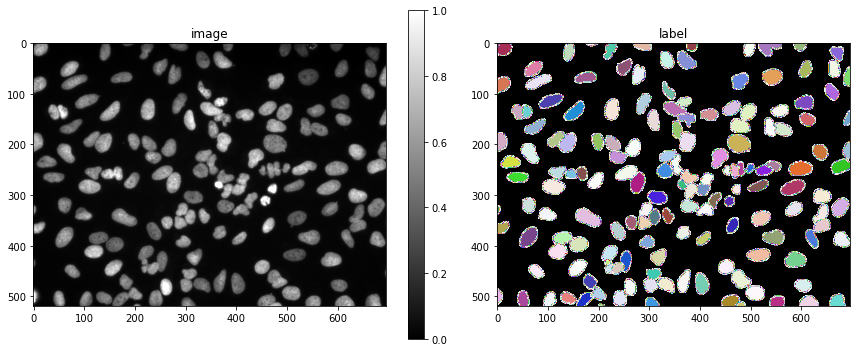

In [76]:
plot_img_label( X[0], Y )

### Data Augmentation

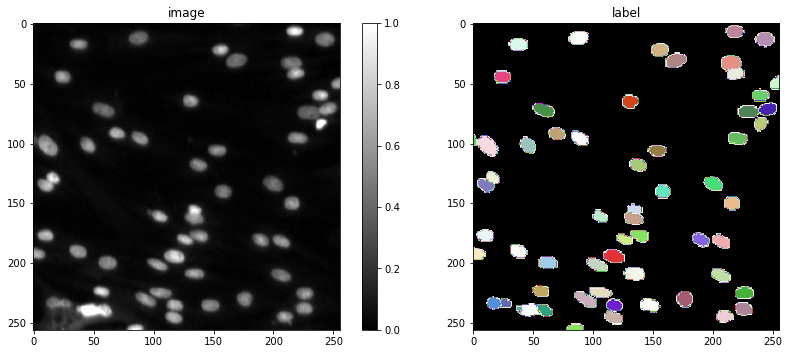

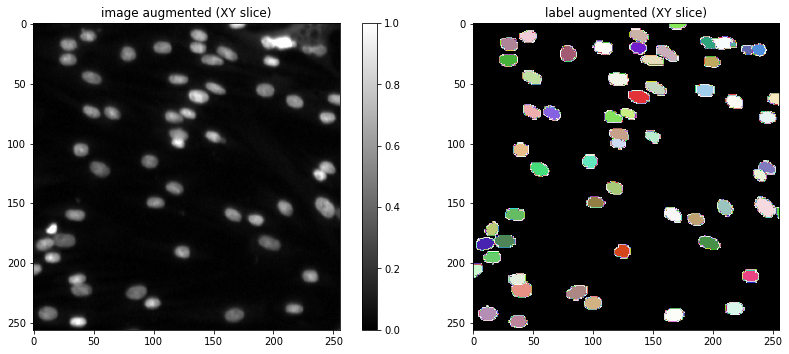

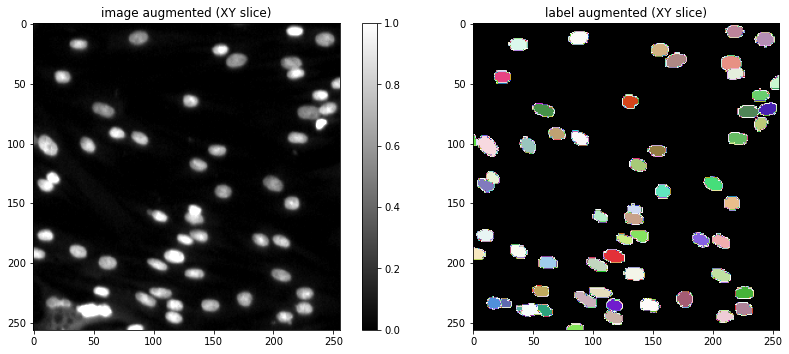

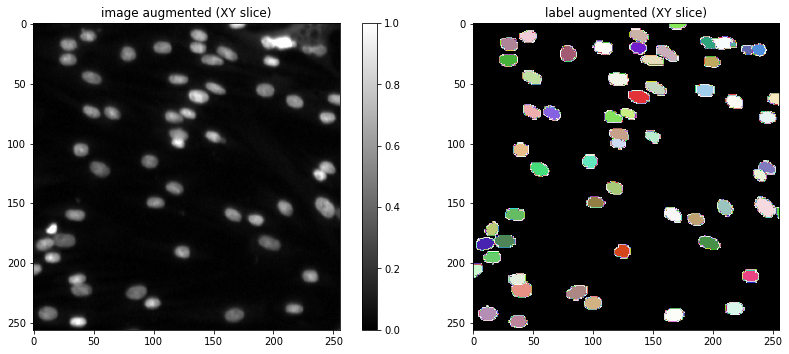

In [77]:
i=1
img, lbl = train_dataloader.dataset.get_image_mask(i, apply_transform=False)
plot_img_label(img[0], lbl)
for _ in range(3):
    img_aug, lbl_aug = train_dataloader.dataset.get_image_mask(i, apply_transform=True)
    plot_img_label(img_aug[0], lbl_aug, img_title="image augmented (XY slice)", lbl_title="label augmented (XY slice)")

### Training

In [78]:
%%time
train(model, train_dataloader, val_dataloader)

[Epoch 1/400] [Steps 100/100] [Loss: 2.1866 Loss_dist: 9.0452 Loss_prob: 0.3775 Loss_prob_class: 0.0000] Duration 0:00:21.673567
[Epoch 1/400] [Batch 17/17] [Val_loss: 1.6904 Val_loss_dist: 7.3035 Val_loss_prob: 0.2297 Val_loss_prob_class: 0.0000]  Duration 0:00:02.573672
learning rate 0.0003000 -> 0.0003000
---
The path <logs\dsb2018_v4\figures> doesn't exists. It will be created!
[Epoch 2/400] [Steps 100/100] [Loss: 1.8882 Loss_dist: 8.0986 Loss_prob: 0.2685 Loss_prob_class: 0.0000] Duration 0:00:09.324183
[Epoch 2/400] [Batch 17/17] [Val_loss: 1.7045 Val_loss_dist: 7.2327 Val_loss_prob: 0.2580 Val_loss_prob_class: 0.0000]  Duration 0:00:01.073208
learning rate 0.0003000 -> 0.0003000
---
[Epoch 3/400] [Steps 100/100] [Loss: 1.5888 Loss_dist: 6.9133 Loss_prob: 0.2061 Loss_prob_class: 0.0000] Duration 0:00:08.535346
[Epoch 3/400] [Batch 17/17] [Val_loss: 1.3757 Val_loss_dist: 6.0772 Val_loss_prob: 0.1603 Val_loss_prob_class: 0.0000]  Duration 0:00:01.000429
learning rate 0.0003000 -> 0

### Threshold optimization

In [79]:
conf.load_epoch="best"
best_model = StarDist2D(conf)

Load path: checkpoints\dsb2018_v4\best.pth cuda:0
Instanciating network
initialize network with normal
Network [StarDistResnet] was created. Total number of parameters: 0.5 million. To see the architecture, do print(network).
<All keys matched successfully>
Optimizers, schedulers and amp_scaler loaded.
Logger loaded.
Loading model from <checkpoints\dsb2018_v4\best.pth>.



stardist_base.py (487): Didn't find thresholds in checkpoint at <logs\dsb2018_v4\thresholds.json>. Using Default Thresholds: {'prob': 0.5, 'nms': 0.4}


In [80]:
print( "Best epoch:", best_model.opt.epoch_count )

Best epoch: 393


In [81]:
X, Y = val_dataloader.dataset.get_all_data()
len(X), len(Y)

(67, 67)

In [82]:
#X, Y = X[:3], Y[:3]

In [83]:
%%time
best_model.optimize_thresholds(X, Y)#, predict_kwargs={ "patch_size":(32, 64, 64) } )

NMS threshold = 0.5:  80%|████████████████████████████████████         | 16/20 [00:18<00:04,  1.18s/it, 0.475 -> 0.815]


Using optimized values: prob_thresh=0.473723, nms_thresh=0.3.
Saving to <logs\dsb2018_v4\thresholds.json>
Wall time: 1min 1s


{'prob': 0.4737231433391571, 'nms': 0.3}

### Evaluation on val set

In [84]:
%%time
Y_pred = [best_model.predict_instance(x)[0] for x in tqdm(X)]

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 14.73it/s]

Wall time: 4.55 s


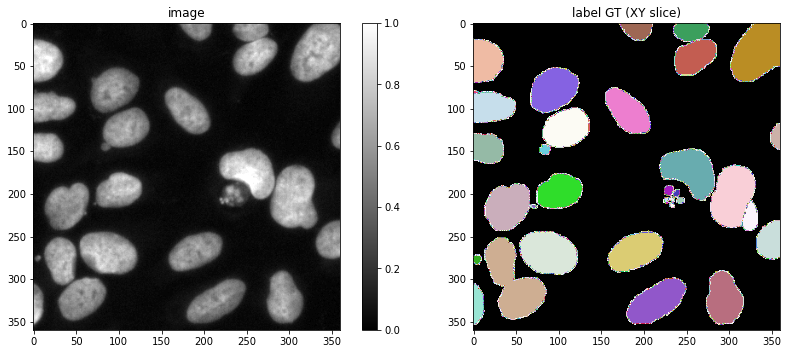

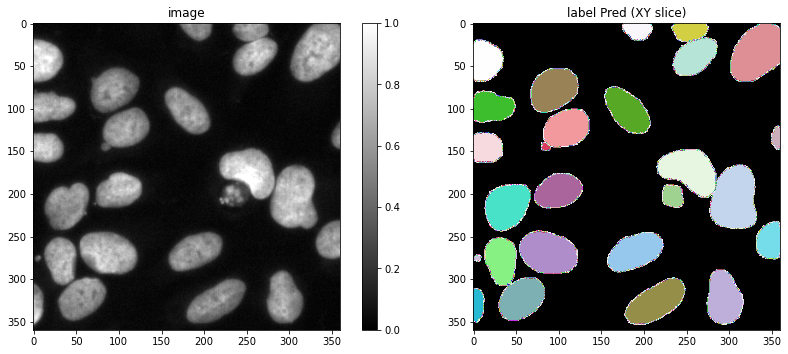

In [85]:
plot_img_label(X[0][0], Y[0], lbl_title="label GT (XY slice)")
plot_img_label(X[0][0], Y_pred[0].astype(np.float32), lbl_title="label Pred (XY slice)")

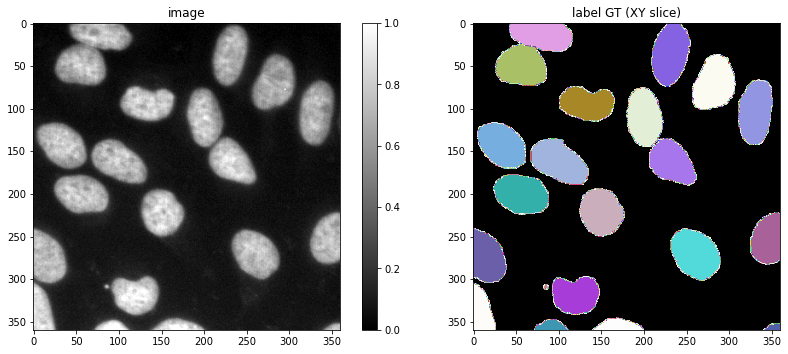

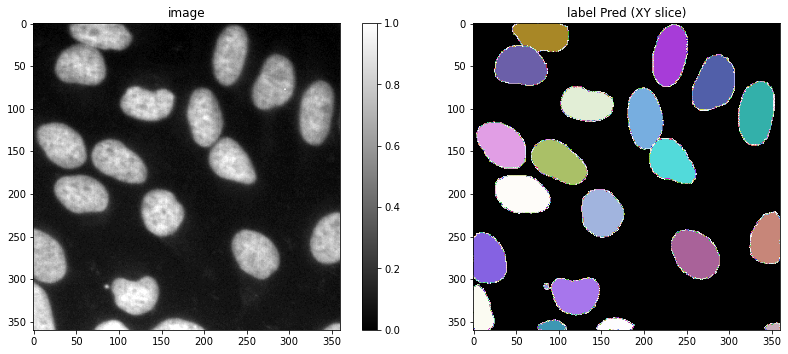

In [86]:
plot_img_label(X[1][0], Y[1], lbl_title="label GT (XY slice)")
plot_img_label(X[1][0], Y_pred[1].astype(np.float32), lbl_title="label Pred (XY slice)")

In [87]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.30it/s]


In [88]:
stats[taus.index(0.7)]

DatasetMatching(criterion='iou', thresh=0.7, fp=304, tp=2042, fn=501, precision=0.8704177323103154, recall=0.8029885961462839, accuracy=0.7172462240955392, f1=0.835344651257926, n_true=2543, n_pred=2346, mean_true_score=0.7119545372180286, mean_matched_score=0.8866309442436077, panoptic_quality=0.7406424169136621, by_image=False)

In [89]:
val_acc = []
for t in np.linspace(0.1, .9, 9):
    t = np.round(t, 1)
    acc = stats[taus.index(t)].accuracy
    val_acc.append(acc)

pd.DataFrame({"threshold": np.array(taus).astype(str), "accuracy": val_acc}).T

,0,1,2,3,4,5,6,7,8
threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
accuracy,0.885461,0.884008,0.881108,0.875336,0.853298,0.807394,0.717246,0.572026,0.295443


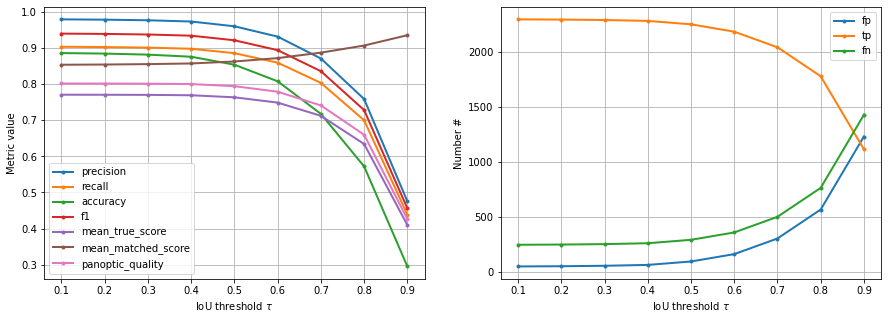

In [90]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

### Evaluation on Test

In [91]:
#best_model.thresholds = {'prob': 0.4737694263458252, 'nms': 0.3}

In [105]:
from pathlib import Path

test_dir = Path( opt.data_dir ) / "test"

test_images_dir = test_dir / "images"
test_mask_dir = test_dir / "masks"

test_image_paths = list( Path(test_images_dir).glob("*.tif") )
test_mask_paths = list( Path(test_mask_dir).glob("*.tif") )

len(test_image_paths), len( test_mask_paths )

(50, 50)

In [106]:
from stardist_tools.csbdeep_utils import normalize

In [107]:
from src.data.utils import load_tif #, save_tif

In [108]:
X = [ normalize( load_tif(image_path).squeeze() )[np.newaxis] for image_path in test_image_paths ]
Y = [ load_tif(mask_path).squeeze().astype(np.uint32) for mask_path in test_mask_paths  ]

len(X), len(Y)

(50, 50)

In [96]:
%%time
Y_pred = [best_model.predict_instance(x)[0] for x in tqdm(X)]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.75it/s]

Wall time: 3.93 s


In [97]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.47it/s]


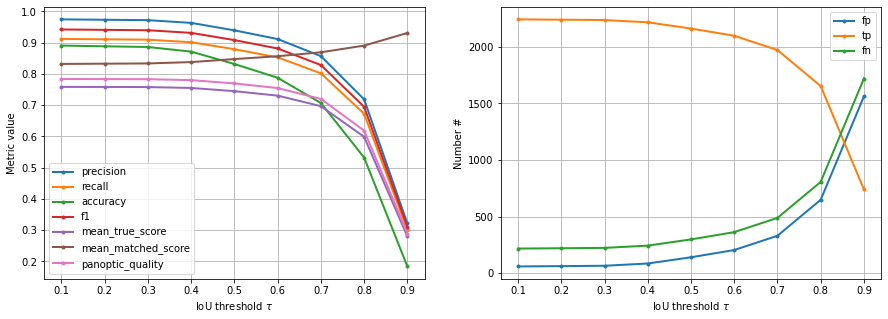

In [98]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [99]:
test_acc = []
for t in np.linspace(0.1, .9, 9):
    t = np.round(t, 1)
    acc = stats[taus.index(t)].accuracy
    test_acc.append(acc)

pd.DataFrame({"threshold": np.array(taus).astype(str), "accuracy": test_acc}).T

,0,1,2,3,4,5,6,7,8
threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
accuracy,0.890433,0.888184,0.885941,0.87112,0.831538,0.787538,0.70681,0.532175,0.183988


In [109]:
# For model thresh prob = 0.4
best_model.thresholds = {'prob': 0.4, 'nms': 0.3}
Y_pred = [best_model.predict_instance(x)[0] for x in tqdm(X)]
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

test_acc = []
for t in np.linspace(0.1, .9, 9):
    t = np.round(t, 1)
    acc = stats[taus.index(t)].accuracy
    test_acc.append(acc)

pd.DataFrame({"threshold": np.array(taus).astype(str), "accuracy": test_acc}).T

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.90it/s]


,0,1,2,3,4,5,6,7,8
threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
accuracy,0.894903,0.89266,0.889677,0.875636,0.834736,0.79022,0.707369,0.531779,0.183029


In [110]:
conf.load_epoch="best"
best_model = StarDist2D(conf)

Load path: checkpoints\dsb2018_v4\best.pth cuda:0
Loading threholds ...
Instanciating network
initialize network with normal
Network [StarDistResnet] was created. Total number of parameters: 0.5 million. To see the architecture, do print(network).
<All keys matched successfully>
Optimizers, schedulers and amp_scaler loaded.
Logger loaded.
Loading model from <checkpoints\dsb2018_v4\best.pth>.



### Evaluation on Train

In [100]:
X, Y = train_dataloader.dataset.get_all_data()
len(X), len(Y)

(380, 380)

In [101]:
%%time
Y_pred = [best_model.predict_instance(x)[0] for x in tqdm(X)]

100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:31<00:00, 11.89it/s]

Wall time: 32 s


In [102]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.94s/it]


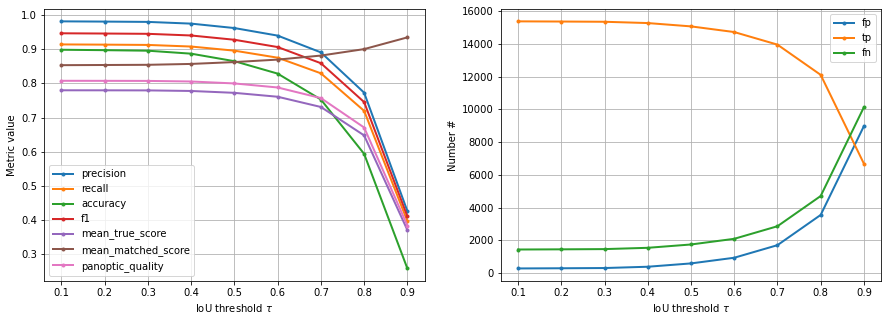

In [103]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [104]:
test_acc = []
for t in np.linspace(0.1, .9, 9):
    t = np.round(t, 1)
    acc = stats[taus.index(t)].accuracy
    test_acc.append(acc)

pd.DataFrame({"threshold": np.array(taus).astype(str), "accuracy": test_acc}).T


,0,1,2,3,4,5,6,7,8
threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
accuracy,0.898359,0.89714,0.89559,0.886895,0.864914,0.828607,0.752859,0.594133,0.259173
